In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from datetime import datetime, timedelta

In [2]:
raw_df = pd.read_csv('../raw_data/data/listings.csv')

In [3]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview',
                'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 
                'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped', 'bathrooms', 
                'calendar_updated', 'license', 'neighbourhood', 'neighbourhood_group_cleansed', 'latitude', 'longitude',
                'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
                'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'review_scores_accuracy', 
                'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                'review_scores_location', 'review_scores_value', 'availability_30', 'availability_60', 'availability_365', 
                'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month', 'host_listings_count', 
                'host_total_listings_count', 'calculated_host_listings_count_entire_homes', 
                'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']

In [4]:
df = raw_df.drop(cols_to_drop, axis=1)

In [5]:
df.set_index('id', inplace=True)

In [6]:
print(f"The dataset contains {len(df)} Airbnb listings")
print(f"The dataset contains {len(df.columns)} columns")
pd.set_option('display.max_columns', len(df.columns)) 
pd.set_option('display.max_rows', 100)
df.head(3)

The dataset contains 44464 Airbnb listings
The dataset contains 26 columns


,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_90,number_of_reviews,first_review,last_review,review_scores_rating,instant_bookable,calculated_host_listings_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,
150097,2011-05-31,within an hour,100%,100%,NaN,t,t,Valley Glen,Private room in bed and breakfast,Private room,3,1 private bath,NaN,2.0,"[""Private pool"", ""Smoke alarm"", ""Garden view"",...",$80.00,31,120,t,0,216,2012-11-02,2020-11-29,4.96,f,4
40667,2010-07-20,within a day,100%,17%,NaN,t,f,Mid-City,Private room in rental unit,Private room,2,1.5 shared baths,NaN,2.0,"[""Smoke alarm"", ""Hot water"", ""Free street park...",$59.00,30,180,t,90,12,2011-07-20,2018-08-24,4.30,f,1
109,2008-06-27,within a few hours,100%,0%,f,t,t,Culver City,Entire condo,Entire home/apt,6,2 baths,2.0,2.0,"[""Smoke alarm"", ""Garden view"", ""Pool view"", ""R...",$129.00,30,730,t,3,2,2011-08-15,2016-05-15,4.00,f,1


In [7]:
df.replace({'f': 0, 't': 1}, inplace=True)

In [8]:
df['bathrooms_text'] = df['bathrooms_text'].str.extract(pat='(\d+)', expand=False)
df['bathrooms_text'] = df['bathrooms_text'].astype('float')

In [9]:
#change price column from object to float and remove special characters
char_remove = {'$':'', ',':''}
for key, value in char_remove.items():
    df['price'] = df['price'].str.replace(key, value, regex=True)
    
df['price'] = df['price'].astype('float')

In [10]:
df[['first_review', 'last_review', 'host_since']] = df[['first_review', 'last_review', 'host_since']].apply(pd.to_datetime)

In [11]:
df['host_days_active'] = (datetime(2023, 4, 6) - df.host_since).astype('timedelta64[D]')
df.drop(['host_since'], axis=1, inplace=True)

In [12]:
df['days_since_first_review'] = (datetime(2023, 4, 6) - df.first_review).astype('timedelta64[D]')
df.drop(['first_review'], axis=1, inplace=True)

In [13]:
df['days_since_last_review'] = (datetime(2023, 4, 6) - df.last_review).astype('timedelta64[D]')
df.drop(['last_review'], axis=1, inplace=True)

In [14]:
#df.dtypes

In [15]:
pd.set_option('display.max_columns', len(df.columns)) 
pd.set_option('display.max_rows', 100)
df.head(3)

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_90,number_of_reviews,review_scores_rating,instant_bookable,calculated_host_listings_count,host_days_active,days_since_first_review,days_since_last_review
id,,,,,,,,,,,,,,,,,,,,,,,,,,
150097,within an hour,100%,100%,NaN,1.0,1.0,Valley Glen,Private room in bed and breakfast,Private room,3,1.0,NaN,2.0,"[""Private pool"", ""Smoke alarm"", ""Garden view"",...",80.0,31,120,1,0,216,4.96,0,4,4328.0,3807.0,858.0
40667,within a day,100%,17%,NaN,1.0,0.0,Mid-City,Private room in rental unit,Private room,2,1.0,NaN,2.0,"[""Smoke alarm"", ""Hot water"", ""Free street park...",59.0,30,180,1,90,12,4.30,0,1,4643.0,4278.0,1686.0
109,within a few hours,100%,0%,0.0,1.0,1.0,Culver City,Entire condo,Entire home/apt,6,2.0,2.0,2.0,"[""Smoke alarm"", ""Garden view"", ""Pool view"", ""R...",129.0,30,730,1,3,2,4.00,0,1,5396.0,4252.0,2517.0


In [16]:
df.drop(['property_type', 'amenities'], axis=1, inplace=True)

In [17]:
df.host_response_time.fillna("unknown", inplace=True)
df['host_response_time'].value_counts()

within an hour        25894
unknown                9975
within a few hours     5697
within a day           2233
a few days or more      665
Name: host_response_time, dtype: int64

In [18]:
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

In [19]:
df.host_response_rate = pd.cut(df.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       26870
unknown     9975
90-99%      3854
50-89%      2858
0-49%        907
Name: host_response_rate, dtype: int64

In [20]:
df.dtypes

host_response_time                 object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                 float64
host_has_profile_pic              float64
host_identity_verified            float64
neighbourhood_cleansed             object
room_type                          object
accommodates                        int64
bathrooms_text                    float64
bedrooms                          float64
beds                              float64
price                             float64
minimum_nights                      int64
maximum_nights                      int64
has_availability                    int64
availability_90                     int64
number_of_reviews                   int64
review_scores_rating              float64
instant_bookable                    int64
calculated_host_listings_count      int64
host_days_active                  float64
days_since_first_review           float64
days_since_last_review            

In [21]:
X = df.drop(columns = ['price'])
print("X: ", type(X), X.shape)

X:  <class 'pandas.core.frame.DataFrame'> (44464, 23)


In [22]:
y = df['price']
print("y: ", type(y), y.shape)

y:  <class 'pandas.core.series.Series'> (44464,)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train.shape, X_test.shape

((35571, 23), (8893, 23))

In [25]:
y_train.shape, y_test.shape

((35571,), (8893,))

In [26]:
cat_list = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'neighbourhood_cleansed', 'room_type']
names_train = X_train[cat_list]
names_test = X_test[cat_list]
X_train.drop(columns=cat_list, inplace=True)
X_test.drop(columns=cat_list, inplace=True)
X_train.shape, X_test.shape

((35571, 18), (8893, 18))

In [27]:
X_train.dtypes

host_is_superhost                 float64
host_has_profile_pic              float64
host_identity_verified            float64
accommodates                        int64
bathrooms_text                    float64
bedrooms                          float64
beds                              float64
minimum_nights                      int64
maximum_nights                      int64
has_availability                    int64
availability_90                     int64
number_of_reviews                   int64
review_scores_rating              float64
instant_bookable                    int64
calculated_host_listings_count      int64
host_days_active                  float64
days_since_first_review           float64
days_since_last_review            float64
dtype: object

In [28]:
X_test.dtypes

host_is_superhost                 float64
host_has_profile_pic              float64
host_identity_verified            float64
accommodates                        int64
bathrooms_text                    float64
bedrooms                          float64
beds                              float64
minimum_nights                      int64
maximum_nights                      int64
has_availability                    int64
availability_90                     int64
number_of_reviews                   int64
review_scores_rating              float64
instant_bookable                    int64
calculated_host_listings_count      int64
host_days_active                  float64
days_since_first_review           float64
days_since_last_review            float64
dtype: object

In [33]:
y_train.mean()

282.3223974586039

In [29]:
pipeline = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [30]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [31]:
y_tr_pred = pipeline.predict(X_train)
y_te_pred = pipeline.predict(X_test)

In [34]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.14188267412722955, 0.2790846725210322)

In [35]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(188.5948841735204, 175.58534413285358)

In [36]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(756288.2178421563, 250524.82584510118)

In [ ]:
#numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
#categorical_features = X_train.select_dtypes(include=['object']).columns

In [ ]:
#numeric_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median'))  
#])

#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),  
#])


In [ ]:
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', numeric_transformer, numeric_features),
#        ('cat', categorical_transformer, categorical_features)
#    ])

In [ ]:
#model = RandomForestRegressor()  # You can choose a different model
#pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            #('model', model)])

In [ ]:
#pipeline.fit(X_train, y_train)

In [37]:
#refining the linear model

pipeline = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func=f_regression),
    LinearRegression()
)

In [38]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001D4D7165F30>)),
                ('linearregression', LinearRegression())])

In [39]:
y_tr_pred = pipeline.predict(X_train)
y_te_pred = pipeline.predict(X_test)

In [40]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.14082426120431013, 0.27736385879698455)

In [41]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(185.1725764575868, 172.16182694046998)

In [51]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [52]:
lr_grid_cv = GridSearchCV(pipeline, param_grid=grid_params, cv=5, n_jobs=-1)

In [53]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001D4D7165F30>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18]})

In [54]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [55]:
lr_grid_cv.best_params_

{'selectkbest__k': 18}

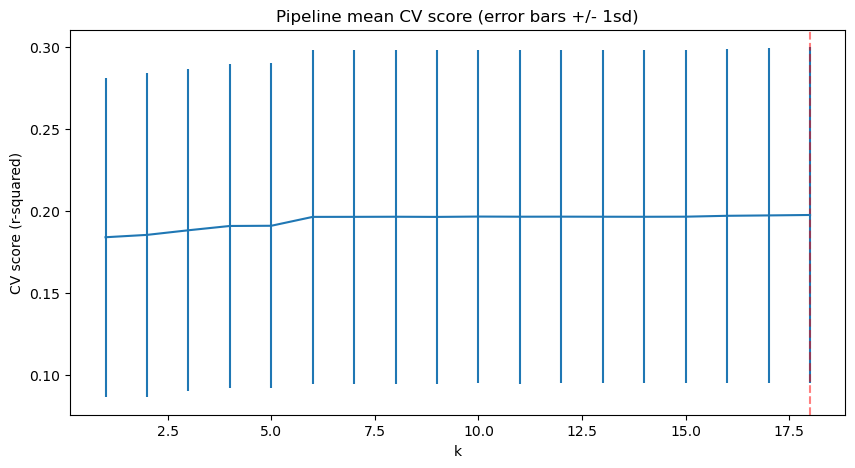

In [56]:
best_k  = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10,5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [57]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [58]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

bathrooms_text                    304.047119
accommodates                      129.435869
availability_90                    33.863779
review_scores_rating               15.139809
maximum_nights                     14.477619
bedrooms                           11.574201
host_days_active                   10.555788
host_identity_verified             -0.147694
days_since_last_review             -1.089277
number_of_reviews                  -1.248455
days_since_first_review            -2.129867
host_has_profile_pic               -2.410846
minimum_nights                     -2.688051
instant_bookable                   -6.253341
host_is_superhost                  -8.016267
has_availability                  -24.080639
calculated_host_listings_count    -62.144135
beds                              -84.418735
dtype: float64